# Outlier Detection

After we did the feature engineering and we defined new features based on the original ones, we can now detect the outliers in the dataset. In this notebook we will do an outlier detection exploiting the new features we created and the algorithms we saw during the course. 

In [87]:
from os import path
import pandas as pd

### Cyclists' outlier detection

In this section we will detect the outliers defined in the cyclist_analysis.ipynb notebook.
For the cyclists we use the following features:
- `weight`: the weight of the cyclist 
- `height`: the height of the cyclist
- `birth_year`: the birth year of the cyclist
- `bmi`: the body mass index of the cyclist
- `career_points`: the career points of the cyclist           
- `career_duration(days)`: the career duration of the cyclist in days   
- `career_duration(races)`: the career duration of the cyclist in years  
- `debut_year`: the first year where the cyclist competed              
- `avg_pos`: the average position of the cyclist                 

In [88]:
datasetname = path.join('..', 'dataset', 'cyclists_final_enhanced.csv')
cyclists = pd.read_csv(datasetname)

Since `weight`, `height`, `bmi`, `career_points`, `avg_pos` follow approximatively normal distribution, for this features we will use the Gaussian Mixture Model to detect the outliers because it particularly fits data with that distributions. 

In [89]:
from sklearn.mixture import GaussianMixture
import numpy
import seaborn

data_only_dataset = cyclists[['weight']]
k = 5
algorithm = GaussianMixture(n_components=k)
algorithm.fit(data_only_dataset.values)

outlier_degrees_per_normal = algorithm.predict_proba(data_only_dataset.values)
outlier_degrees = outlier_degrees_per_normal.max(axis=1)

cyclists.loc[:, "density_degree"] = outlier_degrees

<Axes: >

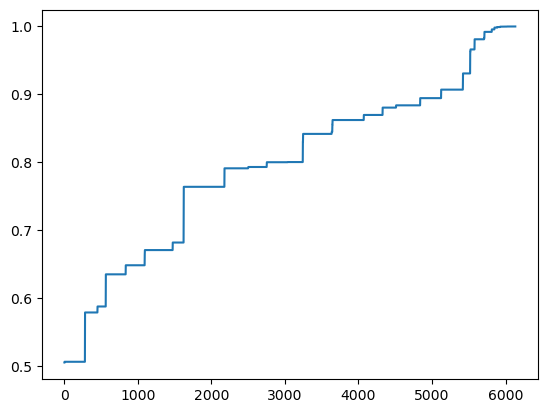

In [90]:
sorted_outlier_degrees = sorted(outlier_degrees)
outlier_degrees_cdf = numpy.cumsum(sorted_outlier_degrees)

seaborn.lineplot(
    x=range(cyclists.shape[0]),
    y=sorted_outlier_degrees
)

The curve rises smoothly, with a few minor jumps, implying that most cyclists have density degrees that increase progressively, so there are no extreme outliers.

In [91]:
from sklearn.mixture import GaussianMixture
import numpy
import seaborn

data_only_dataset = cyclists[['height']]
k = 5
algorithm = GaussianMixture(n_components=k)
algorithm.fit(data_only_dataset.values)

outlier_degrees_per_normal = algorithm.predict_proba(data_only_dataset.values)
outlier_degrees = outlier_degrees_per_normal.max(axis=1)

cyclists.loc[:, "density_degree"] = outlier_degrees

<Axes: >

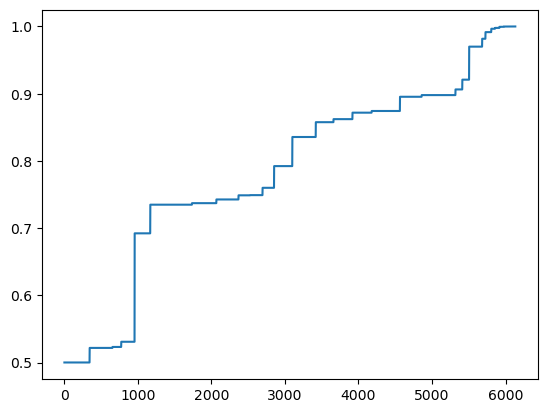

In [92]:
sorted_outlier_degrees = sorted(outlier_degrees)
outlier_degrees_cdf = numpy.cumsum(sorted_outlier_degrees)

seaborn.lineplot(
    x=range(cyclists.shape[0]),
    y=sorted_outlier_degrees
)

This curve also rises gradually but has a few sharp increases, especially noticeable around the middle of the graph (near index 1000). The jumps in the middle and near the end of the plot suggest some minor clusters or groups with distinct density_degree values.

Since `birth_year` and `debut_year` do not follow a normal distribution and present a large variability, we will use the Isolation Forest algorithm to detect the outliers.

In [93]:
from sklearn.ensemble import IsolationForest

data_only_dataset = cyclists[['birth_year']]

max_features = data_only_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features)
algorithm.fit(data_only_dataset)
# the lower, more outliers
outlier_degrees = algorithm.decision_function(data_only_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(data_only_dataset) + 1) / 2 # outlier become +1, inliers become 0. (i map -1, 1)

cyclists.loc[:, "isolation_forest_degree"] = outlier_degrees
cyclists.loc[:, "isolation_forest_scores"] = outlier_scores

<Axes: >

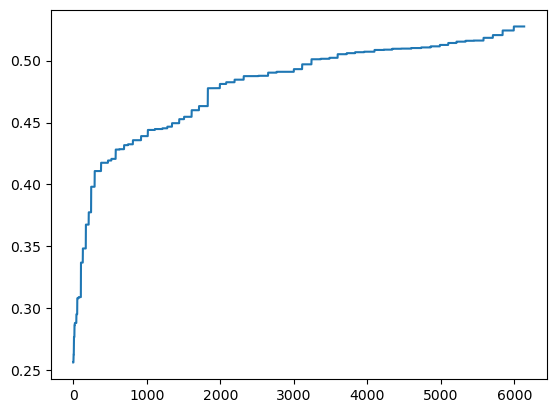

In [94]:
import seaborn
from scipy.spatial.distance import pdist, squareform


sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(cyclists.shape[0]),
    y=sorted_outlier_degrees
)

The curve starts steeply at lower outlier_degree values, then gradually flattens out as it approaches higher values.
Cyclists with lower outlier_degree values are considered more anomalous. Since the curve rises quickly at first, these initial values likely correspond to birth years that are further from the typical range within the dataset.

In [95]:
from sklearn.mixture import GaussianMixture
import numpy
import seaborn

data_only_dataset = cyclists[['bmi']]
k = 5
algorithm = GaussianMixture(n_components=k)
algorithm.fit(data_only_dataset.values)

outlier_degrees_per_normal = algorithm.predict_proba(data_only_dataset.values)
outlier_degrees = outlier_degrees_per_normal.max(axis=1)

cyclists.loc[:, "density_degree"] = outlier_degrees

<Axes: >

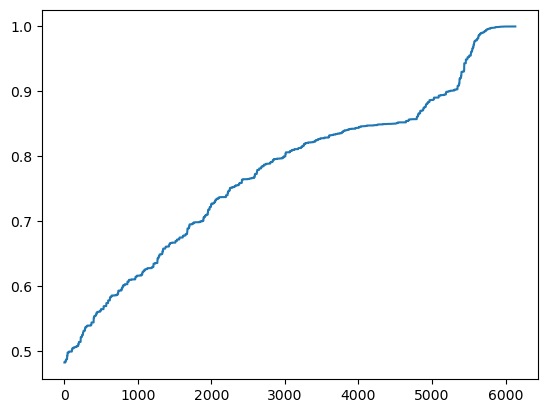

In [96]:
sorted_outlier_degrees = sorted(outlier_degrees)
outlier_degrees_cdf = numpy.cumsum(sorted_outlier_degrees)

seaborn.lineplot(
    x=range(cyclists.shape[0]),
    y=sorted_outlier_degrees
)

This curve grows linearly, with a few minor jumps, suggesting that most cyclists have outlier_degree values that increase progressively. The curve's gradual rise implies that there are no extreme outliers, maybe just a few minor clusters or groups with distinct outlier_degree values between the 5000 and 6000 indexes.

In [97]:
from sklearn.ensemble import IsolationForest

data_only_dataset = cyclists[['career_points']]

max_features = data_only_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features)
algorithm.fit(data_only_dataset)
# the lower, more outliers
outlier_degrees = algorithm.decision_function(data_only_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(data_only_dataset) + 1) / 2 # outlier become +1, inliers become 0. (i map -1, 1)

cyclists.loc[:, "isolation_forest_degree"] = outlier_degrees
cyclists.loc[:, "isolation_forest_scores"] = outlier_scores

<Axes: >

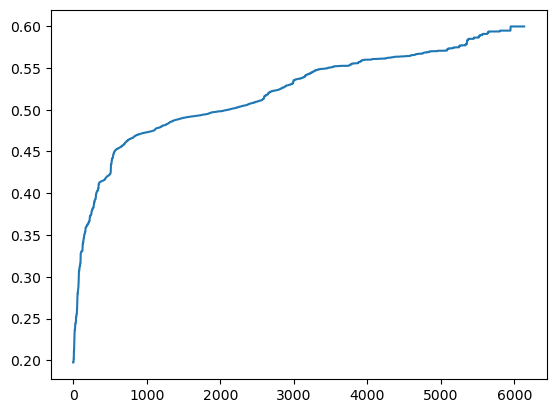

In [98]:
import seaborn
from scipy.spatial.distance import pdist, squareform

sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(cyclists.shape[0]),
    y=sorted_outlier_degrees
)

This curve rises rapidly at first, then gradually flattens out as it approaches higher values. Cyclists with lower outlier_degree values are considered more anomalous. Since the curve rises quickly at first, these initial values likely correspond to debut years that are further from the typical range within the dataset, so we can consider them as outliers.

Since `career_duration(days)` and `career_duration(races)` do not follow a regular distribution (there may be athletes who have a very short career and others with a long career), we will use the $Local Outlier Factor$ algorithm to detect the outliers. By using this algorithm cyclists with an unusually short or long career compared to others will be easily spotted.

In [101]:
from sklearn.neighbors import LocalOutlierFactor

k = 25
data_only_dataset = cyclists[['career_duration(days)']]
algorithm = LocalOutlierFactor(n_neighbors=k)
algorithm.fit(data_only_dataset)

# negated outlier scores: the higher, the more of an outlier
outlier_degrees = - algorithm.negative_outlier_factor_
cyclists.loc[:, "lof_degree"] = outlier_degrees

<Axes: >

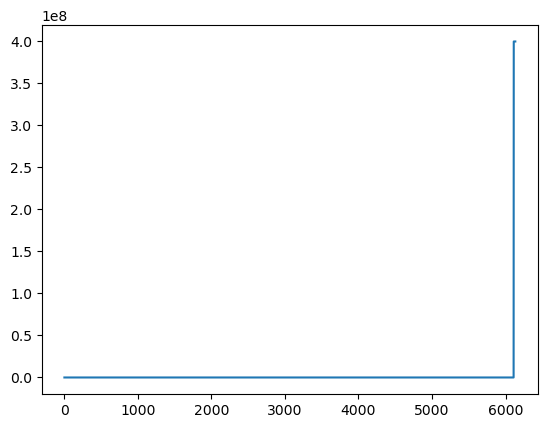

In [102]:
import seaborn
from scipy.spatial.distance import pdist, squareform

sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(cyclists.shape[0]),
    y=sorted_outlier_degrees
)

The curve is almost flat indicating that there are no outliers in the dataset, however near the end of the plot the curve rises perpendicularly, suggesting that there are some cyclists with a career duration that is significantly different from the others.

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

k = 25
data_only_dataset = cyclists[['career_duration(races)']]
algorithm = LocalOutlierFactor(n_neighbors=k)
algorithm.fit(data_only_dataset)

# negated outlier scores: the higher, the more of an outlier
outlier_degrees = - algorithm.negative_outlier_factor_
cyclists.loc[:, "lof_degree"] = outlier_degrees

<Axes: >

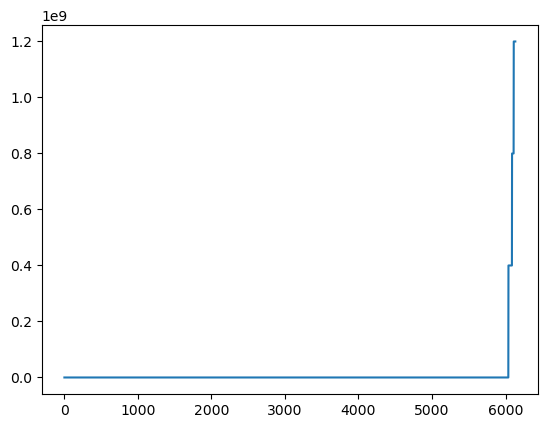

In [104]:
import seaborn
from scipy.spatial.distance import pdist, squareform

sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(cyclists.shape[0]),
    y=sorted_outlier_degrees
)

As before we notice that the curve is almost flat, but near the end of the plot the curve rises rapidly, suggesting that there are some cyclists with a career duration that is significantly different from the others.

In [105]:
from sklearn.ensemble import IsolationForest

data_only_dataset = cyclists[['debut_year']]

max_features = data_only_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features)
algorithm.fit(data_only_dataset)
# the lower, more outliers
outlier_degrees = algorithm.decision_function(data_only_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(data_only_dataset) + 1) / 2 # outlier become +1, inliers become 0. (i map -1, 1)

cyclists.loc[:, "isolation_forest_degree"] = outlier_degrees
cyclists.loc[:, "isolation_forest_scores"] = outlier_scores

<Axes: >

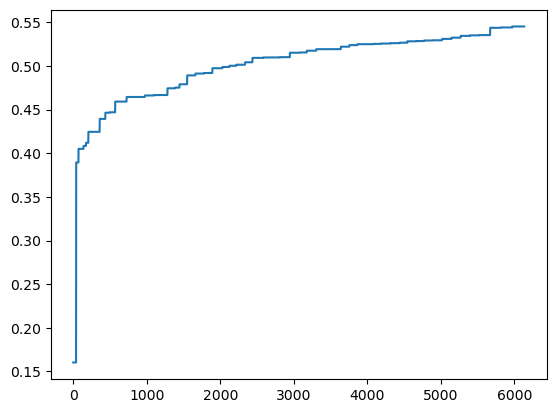

In [106]:
import seaborn
from scipy.spatial.distance import pdist, squareform

sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(cyclists.shape[0]),
    y=sorted_outlier_degrees
)

The curve rises fast at first near the 0 index, then gradually flattens out as it approaches higher values. Cyclists with lower outlier_degree values are considered more anomalous. Since the curve rises quickly at first, these initial values likely correspond to career durations that are further from the typical range within the dataset.

In [107]:
from sklearn.mixture import GaussianMixture
import numpy
import seaborn

data_only_dataset = cyclists[['avg_pos']]
k = 5
algorithm = GaussianMixture(n_components=k)
algorithm.fit(data_only_dataset.values)

outlier_degrees_per_normal = algorithm.predict_proba(data_only_dataset.values)
outlier_degrees = outlier_degrees_per_normal.max(axis=1)

cyclists.loc[:, "density_degree"] = outlier_degrees

<Axes: >

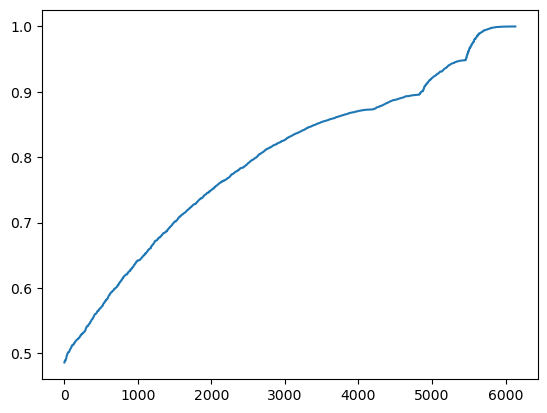

In [108]:
sorted_outlier_degrees = sorted(outlier_degrees)
outlier_degrees_cdf = numpy.cumsum(sorted_outlier_degrees)

seaborn.lineplot(
    x=range(cyclists.shape[0]),
    y=sorted_outlier_degrees
)

The curve rises linearly with few minor jumps suggesting the presence of few minor clusters near the end. The curve's gradual rise implies that there are no extreme outliers, maybe just a few minor clusters or groups with distinct outlier_degree values between the 5000 and 6000 indexes.

## Races' outlier detection

In [109]:
datasetname = path.join('..', 'dataset', 'races_cleaned.csv')
races = pd.read_csv(datasetname)
races = races.drop(races.columns[0], axis=1)

For the races we use the following features:
- `points` 
- `length`
- `climb_total`
- `startlist_quality`
- `position`
- `cyclist_age`
- `year`

In [110]:
from sklearn.ensemble import IsolationForest

data_only_dataset = races[['points']]

max_features = data_only_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features)
algorithm.fit(data_only_dataset)
# the lower, more outliers
outlier_degrees = algorithm.decision_function(data_only_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(data_only_dataset) + 1) / 2 # outlier become +1, inliers become 0. (i map -1, 1)

races.loc[:, "isolation_forest_degree"] = outlier_degrees
races.loc[:, "isolation_forest_scores"] = outlier_scores

<Axes: >

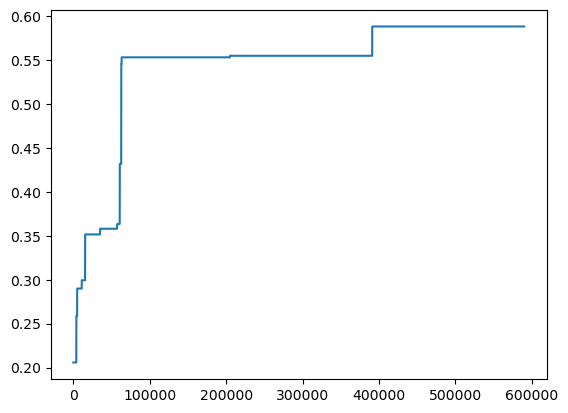

In [111]:
import seaborn
from scipy.spatial.distance import pdist, squareform

sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(races.shape[0]),
    y=sorted_outlier_degrees
)

In [112]:
from sklearn.ensemble import IsolationForest

data_only_dataset = races[['length']]

max_features = data_only_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features)
algorithm.fit(data_only_dataset)
# the lower, more outliers
outlier_degrees = algorithm.decision_function(data_only_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(data_only_dataset) + 1) / 2 # outlier become +1, inliers become 0. (i map -1, 1)

races.loc[:, "isolation_forest_degree"] = outlier_degrees
races.loc[:, "isolation_forest_scores"] = outlier_scores

<Axes: >

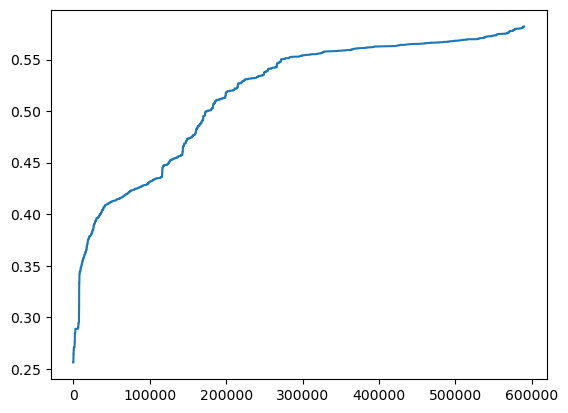

In [113]:
import seaborn
from scipy.spatial.distance import pdist, squareform

sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(races.shape[0]),
    y=sorted_outlier_degrees
)

In [114]:
from sklearn.ensemble import IsolationForest

data_only_dataset = races[['climb_total']]

max_features = data_only_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features)
algorithm.fit(data_only_dataset)
# the lower, more outliers
outlier_degrees = algorithm.decision_function(data_only_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(data_only_dataset) + 1) / 2 # outlier become +1, inliers become 0. (i map -1, 1)

races.loc[:, "isolation_forest_degree"] = outlier_degrees
races.loc[:, "isolation_forest_scores"] = outlier_scores

<Axes: >

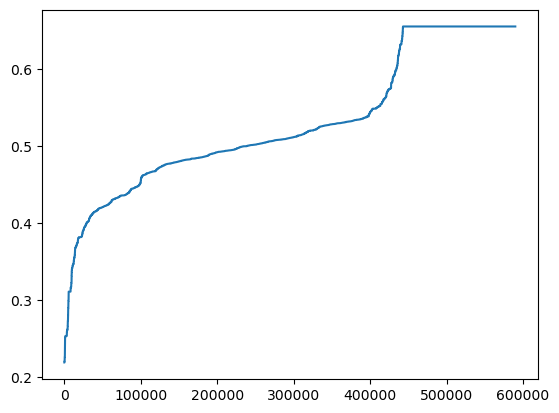

In [115]:
import seaborn
from scipy.spatial.distance import pdist, squareform

sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(races.shape[0]),
    y=sorted_outlier_degrees
)

In [116]:
from sklearn.ensemble import IsolationForest

data_only_dataset = races[['startlist_quality']]

max_features = data_only_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features)
algorithm.fit(data_only_dataset)
# the lower, more outliers
outlier_degrees = algorithm.decision_function(data_only_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(data_only_dataset) + 1) / 2 # outlier become +1, inliers become 0. (i map -1, 1)

races.loc[:, "isolation_forest_degree"] = outlier_degrees
races.loc[:, "isolation_forest_scores"] = outlier_scores

<Axes: >

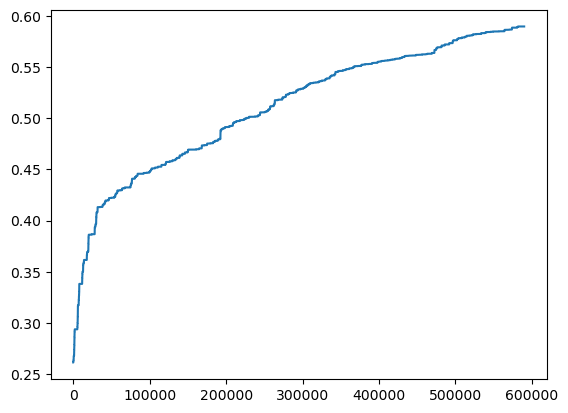

In [117]:
import seaborn
from scipy.spatial.distance import pdist, squareform

sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(races.shape[0]),
    y=sorted_outlier_degrees
)

In [118]:
from sklearn.ensemble import IsolationForest

data_only_dataset = races[['position']]

max_features = data_only_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features)
algorithm.fit(data_only_dataset)
# the lower, more outliers
outlier_degrees = algorithm.decision_function(data_only_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(data_only_dataset) + 1) / 2 # outlier become +1, inliers become 0. (i map -1, 1)

races.loc[:, "isolation_forest_degree"] = outlier_degrees
races.loc[:, "isolation_forest_scores"] = outlier_scores

<Axes: >

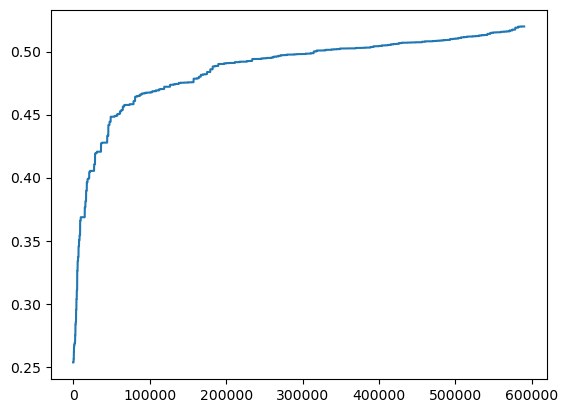

In [119]:
import seaborn
from scipy.spatial.distance import pdist, squareform

sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(races.shape[0]),
    y=sorted_outlier_degrees
)

In [120]:
from sklearn.ensemble import IsolationForest

data_only_dataset = races[['cyclist_age']]

max_features = data_only_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features)
algorithm.fit(data_only_dataset)
# the lower, more outliers
outlier_degrees = algorithm.decision_function(data_only_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(data_only_dataset) + 1) / 2 # outlier become +1, inliers become 0. (i map -1, 1)

races.loc[:, "isolation_forest_degree"] = outlier_degrees
races.loc[:, "isolation_forest_scores"] = outlier_scores

<Axes: >

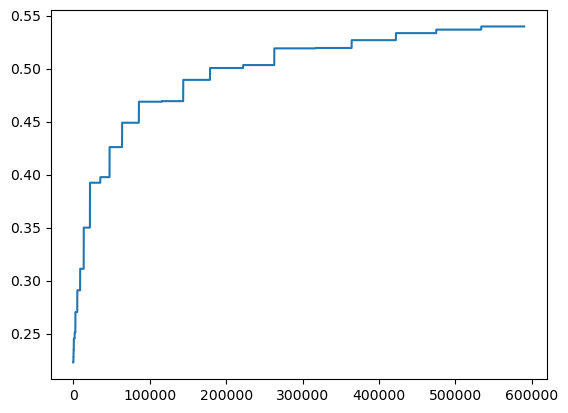

In [121]:
import seaborn
from scipy.spatial.distance import pdist, squareform

sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(races.shape[0]),
    y=sorted_outlier_degrees
)

<Axes: >

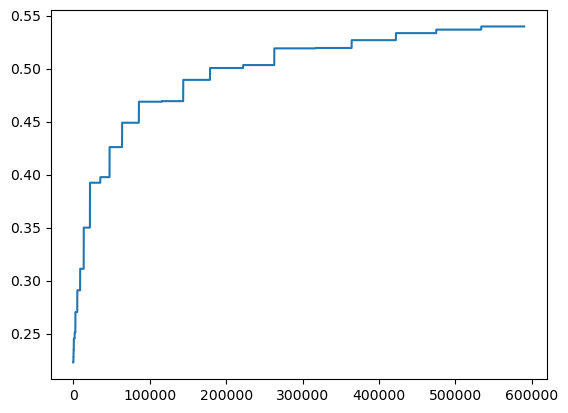

In [122]:
import seaborn
from scipy.spatial.distance import pdist, squareform

sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(races.shape[0]),
    y=sorted_outlier_degrees
)

### LOF Algorithm
TBD: choose if we want to use LOF or Isolation Forest

In [123]:
from sklearn.neighbors import LocalOutlierFactor

k = 25
data_only_dataset = cyclists[['weight']]
algorithm = LocalOutlierFactor(n_neighbors=k)
algorithm.fit(data_only_dataset)

# negated outlier scores: the higher, the more of an outlier
outlier_degrees = - algorithm.negative_outlier_factor_
cyclists.loc[:, "lof_degree"] = outlier_degrees

<Axes: >

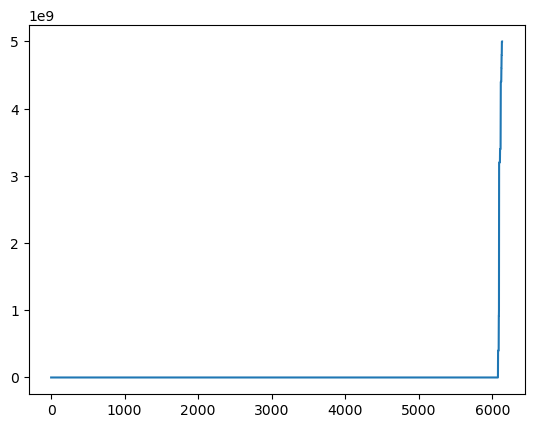

In [124]:
import seaborn
from scipy.spatial.distance import pdist, squareform

sorted_outlier_degrees = sorted(outlier_degrees)

# to achieve comparable degrees among different algorithms,
# we normalize distance-based scores by the maximum possible distance
# distances = squareform(pdist(data_only_dataset.values))
# maximum_possible_radius = distances.max()
# normalization_factor = maximum_possible_radius / k
# normalized_sorted_outlier_degrees = sorted_outlier_degrees / normalization_factor
# dataset_with_outlier_scores.loc[:, "lof_degree_normalized"] = outlier_degrees / normalization_factor

seaborn.lineplot(
    x=range(cyclists.shape[0]),
    y=sorted_outlier_degrees
)

### One-class SVM

In [125]:
from sklearn.svm import OneClassSVM


kernel = "rbf"
# kernel = "linear"
# kernel = "poly"
algorithm = OneClassSVM(kernel=kernel)
algorithm.fit(data_only_dataset)

# this implementation provides two different scores:
#   outlier classification in {+1, -1}
#   outlier scores in R: distance from hyperplane
outlier_classification_scores = algorithm.predict(data_only_dataset)
outlier_distance_scores = algorithm.score_samples(data_only_dataset)

cyclists.loc[:, "oneclass_svm_degree"] = outlier_distance_scores
cyclists.loc[:, "oneclass_svm_degree_binary"] = (outlier_classification_scores  + 1) % 2  # map to {0, 1}

if kernel == "linear":
    support_vectors = data_only_dataset.iloc[algorithm.support_]
    
else:
    support_vectors = None

<Axes: >

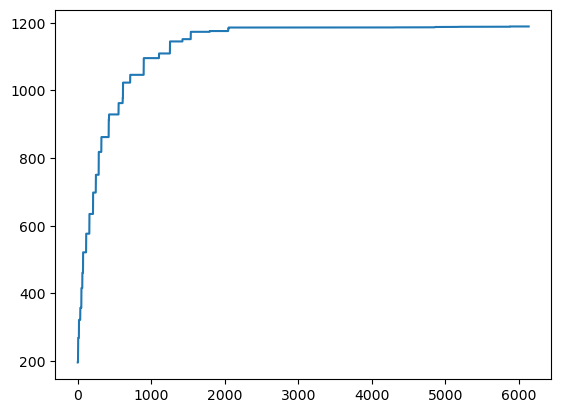

In [126]:
import seaborn
from scipy.spatial.distance import pdist, squareform


sorted_outlier_degrees = sorted(outlier_distance_scores)

# to achieve comparable degrees among different algorithms, we normalize distance-based scores by the maximum possible distance
# normalization_factor = sorted_outlier_degrees[-1]
# normalized_sorted_outlier_degrees = sorted_outlier_degrees / normalization_factor
# dataset_with_outlier_scores.loc[:, "oneclass_svm_degree_normalized"] = outlier_degrees / normalization_factor

seaborn.lineplot(
    x=range(cyclists.shape[0]),
    y=sorted_outlier_degrees
)

### Gaussian Mixture algorithm

In [127]:
from sklearn.mixture import GaussianMixture
import numpy
import seaborn


k = 5
algorithm = GaussianMixture(n_components=k)
algorithm.fit(data_only_dataset.values)

outlier_degrees_per_normal = algorithm.predict_proba(data_only_dataset.values)
outlier_degrees = outlier_degrees_per_normal.max(axis=1)

cyclists.loc[:, "density_degree"] = outlier_degrees

<Axes: >

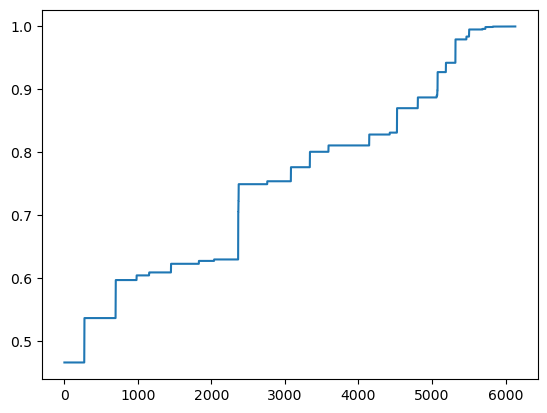

In [128]:
sorted_outlier_degrees = sorted(outlier_degrees)
outlier_degrees_cdf = numpy.cumsum(sorted_outlier_degrees)

seaborn.lineplot(
    x=range(cyclists.shape[0]),
    y=sorted_outlier_degrees
)

### COPOD algorithm

<Axes: >

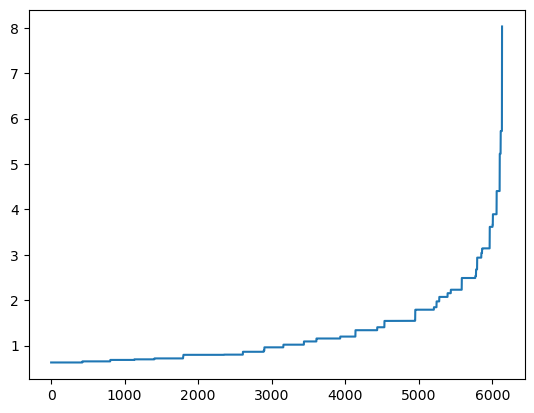

In [129]:
from pyod.models.copod import COPOD  # manifold-based

algorithm = COPOD()
algorithm.fit(data_only_dataset)
outlier_scores = algorithm.decision_function(data_only_dataset)
outlier_labels = algorithm.predict(data_only_dataset)
sorted_outlier_scores = sorted(outlier_scores)
outlier_degrees_cdf = numpy.cumsum(sorted_outlier_scores)

seaborn.lineplot(
    x=range(cyclists.shape[0]),
    y=sorted_outlier_scores
)